In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Target Policy for player
def target_policy_player(ply_ace_flag, ply_sum, dl_card):
    return ply_policy[ply_sum]
# Random behaviour Policy for player
def behavior_policy_player(ply_ace_flag, ply_sum, dl_card):
    if np.random.binomial(1, 0.5) == 1:
        return stand
    return hit
# draw card from the Deck.
def drawCard():
    card = np.random.randint(1, 13)
    if card > 10:
        card = 10    
    return card
# Game 
def blackjack(policy_player, initial_state=None, initial_action=None):
    ply_sum = 0
    ply_history = []
    ply_ace_flag = False # True --> player use ace as 11 otherwise 1
    dl_card1 = 0
    dl_card2 = 0
    dl_ace_flag = False
    if initial_state is None:
        n_ace = 0
        while ply_sum < 12:
            card = drawCard()
            if card == 1:
                n_ace += 1
                card = 11
                ply_ace_flag = True
            ply_sum += card
        if ply_sum > 21:
            ply_sum -= 10
            if n_ace == 1:
                ply_ace_flag = False
        #get dealer cards
        dl_card1 = drawCard()
        dl_card2 = drawCard()
    else:
        ply_ace_flag, ply_sum, dl_card1 = initial_state
        dl_card2 = drawCard()

    state = [ply_ace_flag, ply_sum, dl_card1]
        
   
    dl_sum = 0
    if dl_card1 == 1 and dl_card2 != 1:
        dl_sum += 11 + dl_card2
        dl_ace_flag = True
    elif dl_card1 != 1 and dl_card2 == 1:
        dl_sum += dl_card1 + 11
        dl_ace_flag = True
    elif dl_card1 == 1 and dl_card2 == 1:
        dl_sum += 1 + 11
        dl_ace_flag = True
    else:
        dl_sum += dl_card1 + dl_card2
   
    while True:
        if initial_action is not None:
            action = initial_action
            initial_action = None
        else:
            action = policy_player(ply_ace_flag, ply_sum, dl_card1)
        ply_history.append([(ply_ace_flag, ply_sum, dl_card1), action])

        if action == stand:
            break
         # HIT   
        ply_sum += drawCard()
        # BUSTS
        if ply_sum > 21:
            #  Avoid busting
            if ply_ace_flag == True:
                ply_sum -= 10
                ply_ace_flag = False
            else:
                # Player loses
                return state, -1, ply_history
    # dealer's turn
    while True:
        # get action based on current sum
        action = dl_policy[dl_sum]
        if action == stand:
            break
        # HIT
        new_card = drawCard()
        if new_card == 1 and dl_sum + 11 < 21:
            dl_sum += 11
            dl_ace_flag = True
        else:
            dl_sum += new_card
        # BUST
        if dl_sum > 21:
            if dl_ace_flag == True:
            #  Avoid busting and continue
                dl_sum -= 10
                dl_ace_flag = False
            else:
            # otherwise dealer loses
                return state, 1, ply_history
     # compare the sum between player and dealer
    if ply_sum > dl_sum:
        return state, 1, ply_history
    elif ply_sum == dl_sum:
        return state, 0, ply_history
    else:
        return state, -1, ply_history

In [3]:
def MC_OFF_POLICY(episodes):
    initial_state = [True, 13, 2]

    rhos = []
    returns = []

    for i in range(0, episodes):
        _, reward, player_trajectory = blackjack(behavior_policy_player, initial_state=initial_state)

        # get the importance ratio
        numerator = 1.0
        denominator = 1.0
        for (usable_ace, player_sum, dealer_card), action in player_trajectory:
            if action == target_policy_player(usable_ace, player_sum, dealer_card):
                denominator *= 0.5
            else:
                numerator = 0.0
                break
        rho = numerator / denominator
        rhos.append(rho)
        returns.append(reward)

    rhos = np.asarray(rhos)
    returns = np.asarray(returns)
    weighted_returns = rhos * returns

    weighted_returns = np.add.accumulate(weighted_returns)
    rhos = np.add.accumulate(rhos)

    ordinary_sampling = weighted_returns / np.arange(1, episodes + 1)

    with np.errstate(divide='ignore',invalid='ignore'):
        weighted_sampling = np.where(rhos != 0, weighted_returns / rhos, 0)

    return ordinary_sampling, weighted_sampling

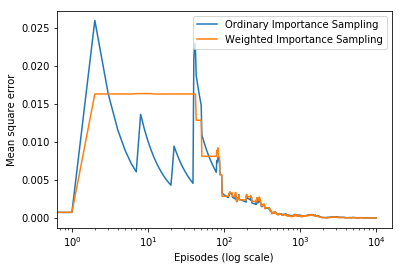

In [4]:
# Define Actions
hit= 0
stand = 1
actions = [hit,stand]

# The Policy that Sticks if the player's sum is 20 or 21 and hit othewise
ply_policy = np.zeros(22)
for i in range(12, 20):
    ply_policy[i] = hit
ply_policy[20] = stand
ply_policy[21] = stand

# Dealer hits and sticks according to a fixed stratergy without choice: 
dl_policy = np.zeros(22)
for i in range(12, 17): 
    dl_policy[i] = hit
for i in range(17, 22):
    dl_policy[i] = stand # sticks on any sum of 17 or greater
true_value = -0.27726
episodes = 10000
runs = 100
error_ordinary = np.zeros(episodes)
error_weighted = np.zeros(episodes)
for i in range(0, runs):
    ordinary_sampling_, weighted_sampling_ = MC_OFF_POLICY(episodes)
    error_ordinary += np.power(ordinary_sampling_ - true_value, 2)
    error_weighted += np.power(weighted_sampling_ - true_value, 2)
    error_ordinary /= runs
    error_weighted /= runs
plt.plot(error_ordinary, label='Ordinary Importance Sampling')
plt.plot(error_weighted, label='Weighted Importance Sampling')
plt.xlabel('Episodes (log scale)')
plt.ylabel('Mean square error')
plt.xscale('log')
plt.legend()
plt.savefig('5_3.png')
plt.show()